In [1]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import pickle

# libreria normalización y estandarización
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler


# librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt

# para calcular las métricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score


import statsmodels.formula.api as smf


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn import tree


from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

# soporte para limpieza
import sys
sys.path.append("../")

import src.soporte as sp

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (15,10)

In [366]:
df_train = pd.read_csv("../data/train.csv")

In [367]:
df_train.head(3)

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983


In [368]:
df_train_  = df_train.copy()
df_train_ = df_train_[['id', 'carat', 'cut', 'color', 'clarity', 'table', 'x', 'y', 'z', 'price']]

In [369]:
df_elim = df_train_[(df_train_["z"] == 0) | (df_train_["x"] == 0) | (df_train_["y"] == 0)]
df_elim.shape

(17, 10)

In [370]:
df_train2 = df_train_.copy()

In [371]:
df_train2.drop(df_elim.index, axis = 0, inplace = True)

In [332]:
lista_columnas = df_train2.select_dtypes(include = np.number).columns
lista_columnas

Index(['id', 'carat', 'table', 'x', 'y', 'z', 'price'], dtype='object')

In [333]:
# aplicamos la función y sacamos los índices de los outliers.

indice = sp.detectar_outliers(lista_columnas, df_train2)

In [334]:
for k, v in indice.items():
    mediana = df_train2[k].median() # calculamos la media para cada una de las columnas que tenemos en nuestro diccionario
    for i in v: # iteremos por la lista de valores para cada columna
        df_train2.loc[i,k] = mediana 

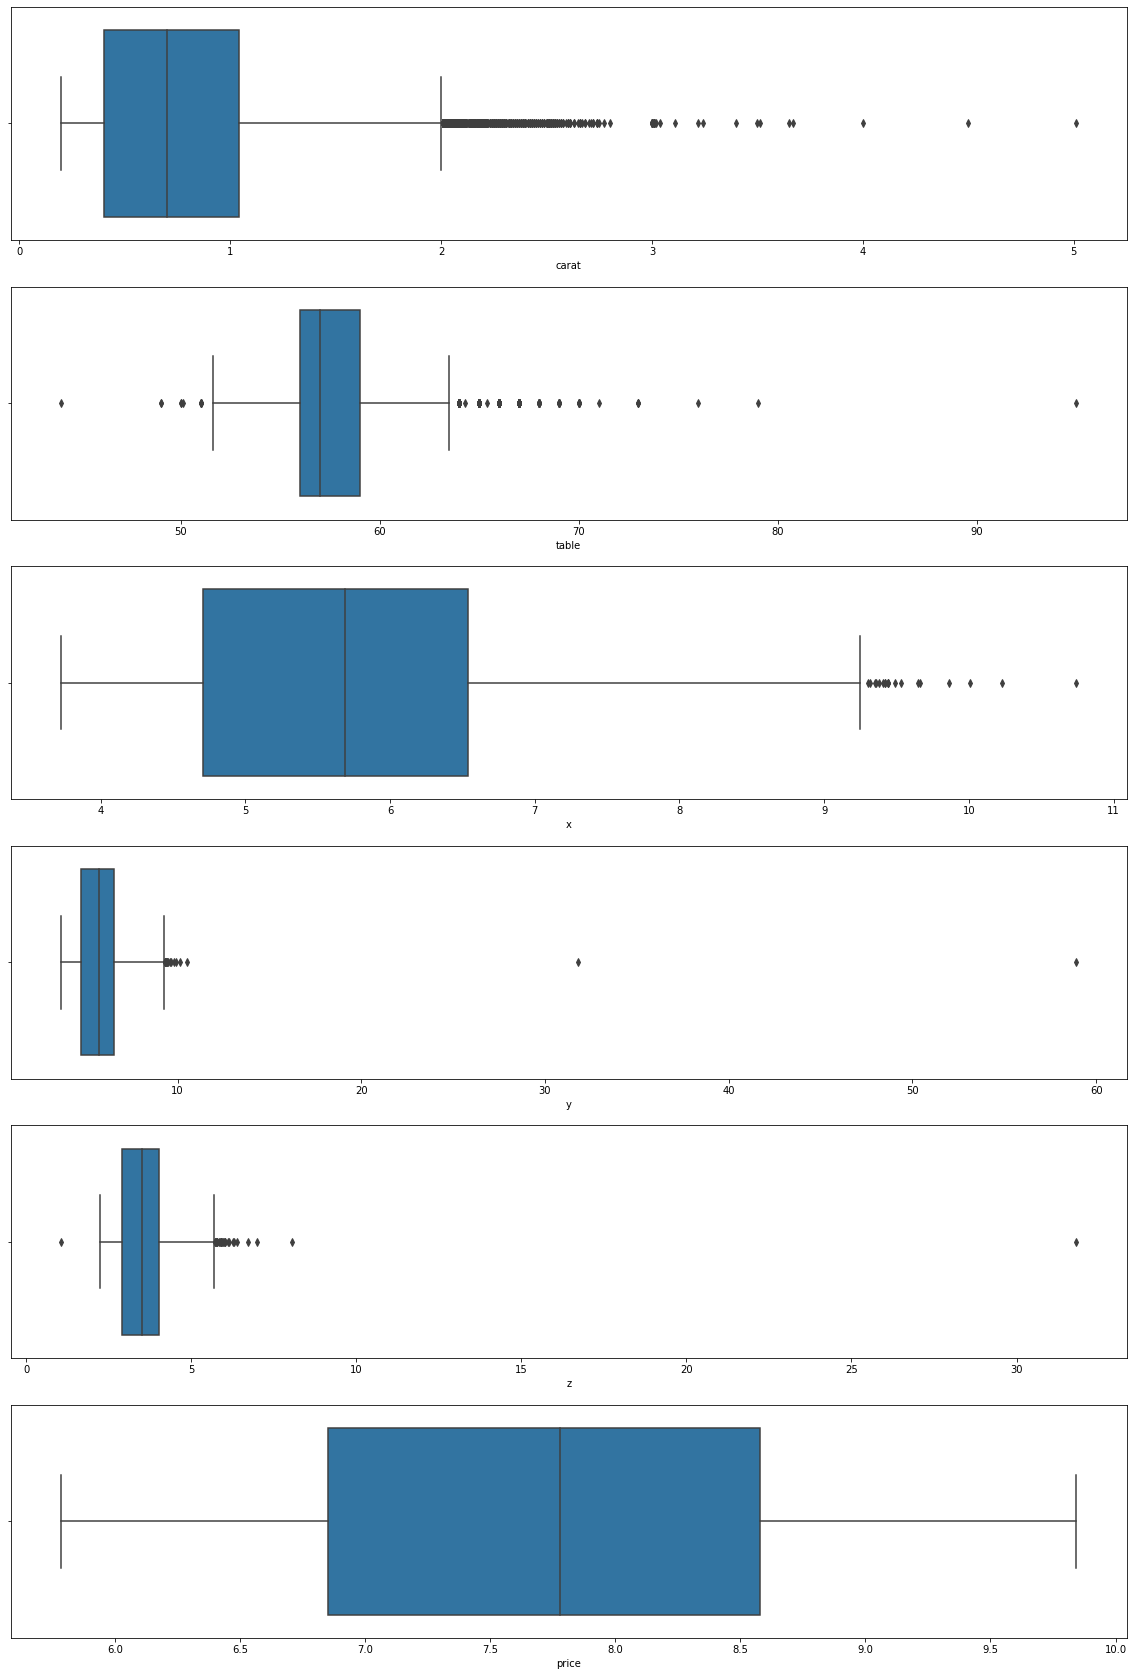

In [372]:
fig, ax = plt.subplots(6, 1, figsize=(20,30))

df_number = df_train2[['carat', 'table', 'x', 'y', 'z', 'price']]
for i in range(len(df_number.columns)):
    sns.boxplot(x = df_number.columns[i], data = df_number, ax = ax[i])
plt.show();

<h2>Estandarización</h2>

In [374]:
robust = RobustScaler()

In [375]:
robust.fit(df_train2[['carat','table', 'x', 'y', 'z']])

RobustScaler()

In [376]:
X_robust = robust.transform(df_train2[['carat', 'table', 'x', 'y', 'z']])

In [377]:
df_train3 = df_train2.copy()

In [378]:
df_train3[['carat', 'table', 'x', 'y', 'z']] = X_robust
df_train3.head()

,id,carat,cut,color,clarity,table,x,y,z,price
0,0,-0.625000,Premium,D,SI2,0.333333,-0.754098,-0.780220,-0.750000,6.353
1,1,0.484375,Ideal,E,VVS2,-0.333333,0.398907,0.417582,0.464286,9.183
2,2,0.031250,Ideal,F,VS2,0.666667,0.010929,0.021978,0.017857,7.983
3,3,0.593750,Very Good,G,SI2,0.000000,0.464481,0.439560,0.535714,8.371
4,4,-0.531250,Premium,G,VS1,0.666667,-0.650273,-0.631868,-0.625000,6.588


In [379]:
with open('../data/modelo_4/estandarizacion.pkl', 'wb') as s:
    pickle.dump(robust, s)

In [380]:
robust_2 = RobustScaler()
robust_2.fit(df_train3[['price']])
X_robust_2 = robust_2.transform(df_train3[['price']])
df_train3[['price']] = X_robust_2

with open('../data/modelo_4/estandarizacion_2.pkl', 'wb') as s:
    pickle.dump(robust_2, s)

<h2>Encoding</h2>

In [381]:
df_train4 = df_train3.copy()

In [382]:
df_train4 = sp.ordinal_encoder(df_train4, "cut", ["Ideal", "Very Good", "Good", "Premium", "Fair"], 4)

In [383]:
df_train4 = sp.ordinal_encoder(df_train4, "color", ["E", "D", "F", "G", "H", "I", "J"], 4)

In [384]:
df_train4 = sp.ordinal_encoder(df_train4, "clarity", ["VVS1", "IF", "VVS2", "VS1", "VS2", "SI1", "I1", "SI2"], 4)

In [385]:
df_train4.head()

,id,carat,cut,color,clarity,table,x,y,z,price,cut_mapeada,color_mapeada,clarity_mapeada
0,0,-0.625000,Premium,D,SI2,0.333333,-0.754098,-0.780220,-0.750000,-0.824754,3,1,7
1,1,0.484375,Ideal,E,VVS2,-0.333333,0.398907,0.417582,0.464286,0.812030,0,0,2
2,2,0.031250,Ideal,F,VS2,0.666667,0.010929,0.021978,0.017857,0.117987,0,2,4
3,3,0.593750,Very Good,G,SI2,0.000000,0.464481,0.439560,0.535714,0.342394,1,3,7
4,4,-0.531250,Premium,G,VS1,0.666667,-0.650273,-0.631868,-0.625000,-0.688837,3,3,3


In [386]:
df = df_train4.copy()
df = df_train4[['carat', 'table', 'x', 'y', 'z', 'cut_mapeada', 'color_mapeada', 'clarity_mapeada', 'price']]
df.head(5)

,carat,table,x,y,z,cut_mapeada,color_mapeada,clarity_mapeada,price
0,-0.625000,0.333333,-0.754098,-0.780220,-0.750000,3,1,7,-0.824754
1,0.484375,-0.333333,0.398907,0.417582,0.464286,0,0,2,0.812030
2,0.031250,0.666667,0.010929,0.021978,0.017857,0,2,4,0.117987
3,0.593750,0.000000,0.464481,0.439560,0.535714,1,3,7,0.342394
4,-0.531250,0.666667,-0.650273,-0.631868,-0.625000,3,3,3,-0.688837


<h2>Decision Tree</h2>

In [387]:
X = df.drop("price", axis = 1)
y = df["price"] 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 42)

In [388]:
y_train.describe()

count    36394.000000
mean         0.003478
std          0.587574
min         -1.152111
25%         -0.536726
50%          0.001735
75%          0.462695
max          1.193175
Name: price, dtype: float64

In [389]:
y_test.describe()

count    4044.000000
mean       -0.006023
std         0.591909
min        -1.131290
25%        -0.538462
50%        -0.023135
75%         0.466744
max         1.191440
Name: price, dtype: float64

In [390]:
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [391]:
max_features = np.sqrt(len(X_train.columns))
max_features

2.8284271247461903

In [392]:
print(regressor.tree_.max_depth)

35


In [393]:
y_pred_test_dt = regressor.predict(X_test)
y_pred_train_dt = regressor.predict(X_train)

In [394]:
dt_results1 = sp.metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,0.049219,0.005081,0.071284,0.985493,test,Decission Tree I
1,0.000113,0.000005,0.002260,0.999985,train,Decission Tree I


In [395]:
df_all = dt_results1.copy()

In [396]:
# Generación del GridSearch
# ==============================================================================

# definimos un diccionario con los hiperparámetros que queremos testear. 
param = {"max_depth": [6, 7, 8, 9, 10],
        "min_samples_split": [10, 20, 30, 40, 50, 100],
        "max_features": [4, 5, 6, 7]}

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(),
            param_grid= param,
            cv=10,
            verbose=0,
            n_jobs = -1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [397]:
%%time
gs.fit(X_train, y_train)

CPU times: total: 5.45 s
Wall time: 18.1 s


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8, 9, 10],
                         'max_features': [4, 5, 6, 7],
                         'min_samples_split': [10, 20, 30, 40, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [398]:
best_tree = gs.best_estimator_
best_tree

DecisionTreeRegressor(max_depth=10, max_features=7, min_samples_split=10)

In [399]:
y_pred_test_dt = gs.predict(X_test)
y_pred_train_dt = gs.predict(X_train)

In [400]:
dt_results2 = sp.metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,0.052911,0.004811,0.069364,0.986264,test,Decission Tree II
1,0.047430,0.003805,0.061684,0.988979,train,Decission Tree II


In [401]:
df_all = pd.concat([df_all, dt_results2 ], axis = 0)
df_all

,MAE,MSE,RMSE,R2,set,modelo
0,0.049219,0.005081,0.071284,0.985493,test,Decission Tree I
1,0.000113,0.000005,0.002260,0.999985,train,Decission Tree I
0,0.052911,0.004811,0.069364,0.986264,test,Decission Tree II
1,0.047430,0.003805,0.061684,0.988979,train,Decission Tree II


<h2>Random Forest</h2>

In [299]:
param = {"max_depth": [8, 9, 10],
        "min_samples_split": [10, 20, 40, 50],
        "max_features": [4, 5, 6, 7]}

bosque = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid= param,
            cv=10,
            verbose=0,
            n_jobs = -1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [300]:
%%time
bosque.fit(X_train, y_train)

KeyboardInterrupt: 

In [258]:
bos = bosque.best_estimator_
bos

RandomForestRegressor(max_depth=10, max_features=6, min_samples_split=10)

In [259]:
y_pred_test_rf = bos.predict(X_test)
y_pred_train_rf = bos.predict(X_train)

In [260]:
rf_results = sp.metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
rf_results

,MAE,MSE,RMSE,R2,set,modelo
0,0.045845,0.003593,0.059945,0.989741,test,Random Forest
1,0.042164,0.002997,0.054746,0.991319,train,Random Forest


In [261]:
df_all = pd.concat([df_all, rf_results ], axis = 0)
df_all

,MAE,MSE,RMSE,R2,set,modelo
0,0.049219,0.005081,0.071284,0.985493,test,Decission Tree I
1,0.000113,0.000005,0.002260,0.999985,train,Decission Tree I
0,0.051983,0.004623,0.067990,0.986803,test,Decission Tree II
1,0.048143,0.003891,0.062377,0.988730,train,Decission Tree II
0,0.045845,0.003593,0.059945,0.989741,test,Random Forest
1,0.042164,0.002997,0.054746,0.991319,train,Random Forest


<h2>Gradient</h2>

In [ ]:
param = {"max_depth": [8, 9, 10],
         "min_samples_split": [10, 20, 50, 80, 100],
         "max_features": [4, 5, 6, 7], 
         "min_samples_leaf": [10, 20, 50, 80, 100, 130]}

grid = GridSearchCV(
        estimator  = GradientBoostingRegressor(),
        param_grid = param,
        cv=10,
        verbose=0,
        n_jobs = -1,
        return_train_score = True,
        scoring="neg_mean_squared_error")

In [ ]:
grid.fit(X = X_train, y = y_train)

In [ ]:
grid.best_params_

In [ ]:
y_pred_gb_test= grid.predict(X_test)
y_pred_gb_train= grid.predict(X_train)

In [ ]:
grid_result = sp.metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Gradient")

In [ ]:
df_all = pd.concat([df_all, grid_result ], axis = 0)
df_all

In [262]:
with open('../data/modelo_4/mejor_modelo.pkl', 'wb') as modelo:
        pickle.dump(bosque, modelo)